In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
%matplotlib notebook
import timeit
start_time=timeit.default_timer()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/pmbc3k.h5ad'

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.0.4 anndata==0.6.1 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/'
untreated = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
untreated.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
untreated.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
print(untreated.shape)

... reading from cache file ./cache/home-ehamilton-ProjectSummer2018-GRCh38-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
(6617, 33694)


In [3]:
untreated.var_names_make_unique()

In [4]:
sc.pp.filter_cells(untreated, min_genes=200)
sc.pp.filter_genes(untreated, min_cells=3)

In [5]:
mito_genes = [name for name in untreated.var_names if name.startswith('MT-')]
untreated.obs['percent_mito']=np.sum( untreated[:, mito_genes].X, axis=1).A1 / np.sum(untreated.X, axis=1).A1
untreated.obs['n_counts']= untreated.X.sum(axis=1).A1

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


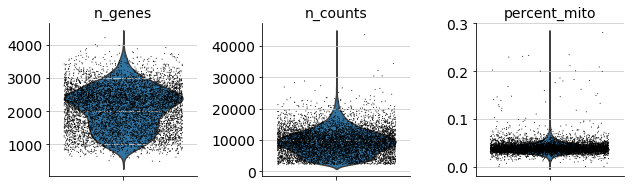

In [6]:
sc.pl.violin(untreated, ['n_genes','n_counts','percent_mito'], jitter=0.4, multi_panel=True)

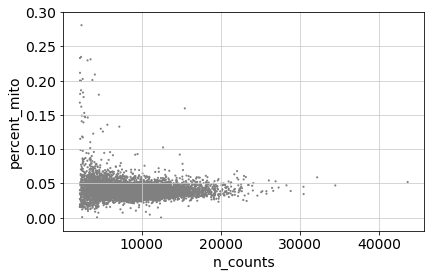

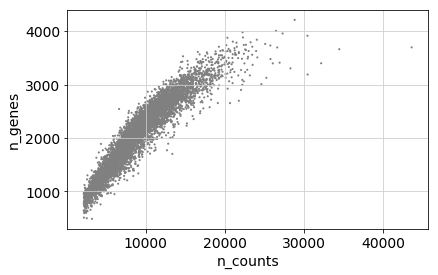

In [7]:
sc.pl.scatter(untreated, x='n_counts',y='percent_mito')
sc.pl.scatter(untreated, x='n_counts',y='n_genes')

In [8]:
untreated = untreated[untreated.obs['n_genes'] < 4000, :]
untreated = untreated[untreated.obs['percent_mito'] < 0.1, :]
print(untreated.shape)

(6578, 15740)


In [9]:
untreated.raw = sc.pp.log1p(untreated, copy=True)

In [10]:
print(untreated.raw)

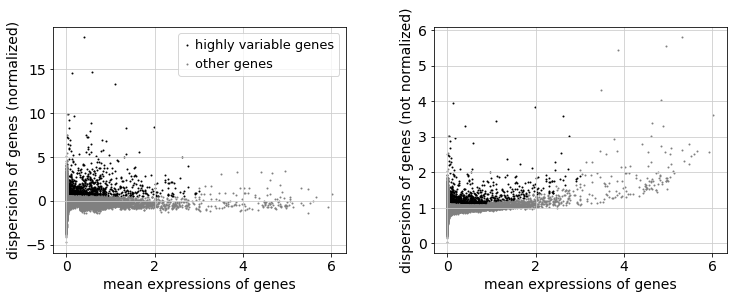

In [11]:
sc.pp.normalize_per_cell(untreated, counts_per_cell_after=20000)
filter_result = sc.pp.filter_genes_dispersion(untreated.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [12]:
untreated = untreated[:, filter_result.gene_subset]

In [13]:
print(untreated.X)

  (0, 0)	2.9664788
  (0, 2)	11.865915
  (0, 4)	2.9664788
  (0, 7)	2.9664788
  (0, 16)	2.9664788
  (0, 19)	2.9664788
  (0, 23)	2.9664788
  (0, 24)	8.899437
  (0, 28)	2.9664788
  (0, 34)	2.9664788
  (0, 35)	20.765352
  (0, 37)	2.9664788
  (0, 38)	2.9664788
  (0, 41)	2.9664788
  (0, 54)	8.899437
  (0, 73)	2.9664788
  (0, 94)	2.9664788
  (0, 102)	2.9664788
  (0, 109)	2.9664788
  (0, 120)	5.9329576
  (0, 136)	2.9664788
  (0, 137)	2.9664788
  (0, 139)	2.9664788
  (0, 142)	5.9329576
  (0, 144)	2.9664788
  :	:
  (6577, 1678)	2.531325
  (6577, 1692)	17.719276
  (6577, 1715)	7.593975
  (6577, 1716)	2.531325
  (6577, 1719)	2.531325
  (6577, 1732)	2.531325
  (6577, 1736)	2.531325
  (6577, 1737)	12.656626
  (6577, 1743)	5.06265
  (6577, 1744)	2.531325
  (6577, 1755)	2.531325
  (6577, 1757)	15.18795
  (6577, 1759)	5.06265
  (6577, 1773)	15.18795
  (6577, 1774)	2.531325
  (6577, 1789)	12.656626
  (6577, 1791)	17.719276
  (6577, 1799)	5.06265
  (6577, 1805)	2.531325
  (6577, 1817)	2.531325
  (6577, 18

In [14]:
sc.pp.log1p(untreated)

In [15]:
sc.pp.scale(untreated, max_value=10)

In [16]:
untreated.write(results_file)

In [17]:
sc.tl.pca(untreated)

In [18]:
from sklearn.cluster import KMeans
import numpy as np

In [19]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(untreated.X)

In [20]:
kmeans.labels_

array([4, 4, 0, ..., 0, 3, 1], dtype=int32)

In [21]:
print(kmeans.labels_)

[4 4 0 ... 0 3 1]


In [22]:
df = pd.DataFrame(kmeans.labels_)
df.columns=['KMean']
df

,KMean
0,4
1,4
2,0
3,4
4,0
5,1
6,1
7,1
8,2
9,1


In [23]:
icantbelievethatworked = pd.merge(untreated.obs, untreated.obs)

In [24]:
W = pd.concat([icantbelievethatworked, df], axis=1, join='inner')

In [79]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/'
outfile = outpath + 'KMeanDownsizedCellListNEW.csv'
W.to_csv(outfile, sep='\t')

In [25]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/'
V = pd.read_csv(path + 'OBSFiveClusterLouvain.csv', sep='\t')

In [26]:
B = pd.merge(V, W, on=['n_counts','n_genes'])
B.groupby(["louvain", "KMean"]).size()

louvain  KMean
0        0        1729
         1         223
         2         812
         3         936
         4         552
1        0         287
         1         910
         2         117
         3           6
         4          17
2        0           5
         1           1
         3           1
         4         631
3        0         120
         1          62
         2          22
         3          84
         4          26
4        0          20
         1           7
         2           3
         3          13
         4           2
dtype: int64

In [27]:
import seaborn as sns
import pandas as pd
import numpy as np

In [28]:
x = ['Louvain','L1','L2','L3','L4','L5']
y = ['KMeans','K1','K2','K5','K4','K3']

In [29]:
intensity = [
    [0.4066, 0.2147, 0.0078, 0.3822, 0.4444],
    [0.0524, 0.6806, 0.0016, 0.1975, 0.1556],
    [0.1298, 0.0127, 0.9890, 0.0828, 0.0444],
    [0.2201, 0.0045, 0.0016, 0.2675, 0.2889],
    [0.1920, 0.0875, 0.0000, 0.0701, 0.0667]
]

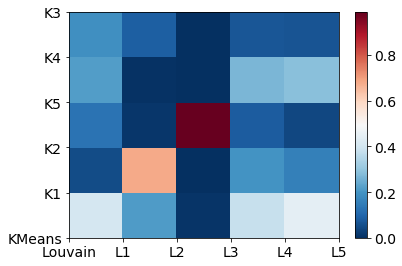

In [30]:
x, y = np.meshgrid(x, y)

intensity = np.array(intensity)

plt.pcolormesh(x, y, intensity)
plt.colorbar()
plt.show()

In [31]:
import random
x=random.sample(range(6577),3000)

In [32]:
untreated_subset3K = untreated[x, :]

In [33]:
untreated_subset3K.var_names_make_unique()

In [34]:
sc.tl.pca(untreated_subset3K)

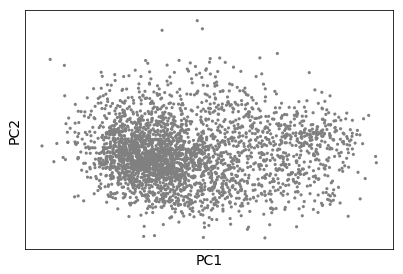

In [35]:
sc.pl.pca_scatter(untreated_subset3K)

In [36]:
kmeans3K = KMeans(n_clusters=5, random_state=0).fit(untreated_subset3K.X)

In [37]:
kmeans3K.labels_

array([2, 4, 4, ..., 3, 2, 3], dtype=int32)

In [38]:
print(kmeans3K.labels_)

[2 4 4 ... 3 2 3]


In [39]:
df3K = pd.DataFrame(kmeans3K.labels_)
df3K.columns=['KMean']
df3K

,KMean
0,2
1,4
2,4
3,4
4,4
5,2
6,4
7,4
8,4
9,2


In [40]:
icantbelievethatworked3K = pd.merge(untreated_subset3K.obs, untreated_subset3K.obs)

In [41]:
KMeans3K = pd.concat([icantbelievethatworked3K, df3K], axis=1, join='inner')

In [42]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 3000/'
outfile = outpath + 'KMeanDownsizedCellList3K_5.csv'
KMeans3K.to_csv(outfile, sep='\t')

In [43]:
x=random.sample(range(6577),1000)

In [44]:
untreated_subset1K = untreated[x, :]

In [45]:
untreated_subset1K.var_names_make_unique()

In [46]:
sc.tl.pca(untreated_subset1K)

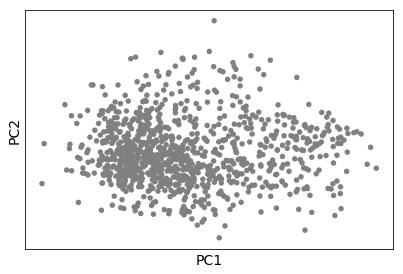

In [47]:
sc.pl.pca_scatter(untreated_subset1K)

In [48]:
kmeans1K = KMeans(n_clusters=5, random_state=0).fit(untreated_subset1K.X)

In [49]:
kmeans1K.labels_

array([0, 0, 4, 3, 1, 1, 1, 3, 4, 4, 3, 0, 1, 1, 3, 1, 3, 4, 3, 3, 3, 3,
       1, 1, 3, 3, 4, 4, 3, 3, 1, 3, 1, 1, 3, 3, 1, 4, 1, 3, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 3, 3, 1, 4, 3, 3, 4, 3, 0, 1, 3, 4, 4, 3, 3,
       1, 4, 0, 4, 0, 1, 1, 4, 1, 0, 3, 1, 0, 3, 1, 1, 0, 1, 3, 1, 4, 0,
       4, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 1, 3, 3, 3, 3, 4, 4, 3, 1, 4,
       0, 3, 3, 4, 1, 4, 1, 1, 1, 1, 4, 1, 0, 1, 3, 3, 4, 3, 3, 3, 1, 1,
       3, 3, 4, 1, 1, 1, 1, 3, 1, 4, 3, 0, 3, 1, 4, 0, 1, 1, 1, 1, 0, 3,
       3, 1, 3, 4, 3, 3, 4, 3, 1, 1, 1, 4, 4, 4, 3, 0, 3, 1, 0, 3, 0, 3,
       1, 0, 1, 3, 4, 0, 4, 1, 4, 3, 3, 0, 3, 0, 0, 3, 4, 3, 3, 3, 3, 1,
       3, 3, 3, 4, 1, 3, 1, 4, 4, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1,
       0, 1, 1, 0, 4, 1, 0, 0, 1, 1, 4, 0, 3, 0, 1, 0, 3, 3, 1, 3, 4, 0,
       0, 0, 3, 4, 1, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 1, 3, 0, 4, 0, 3, 3,
       1, 1, 0, 1, 4, 4, 0, 3, 3, 1, 3, 3, 3, 3, 4, 1, 4, 3, 3, 3, 3, 0,
       3, 1, 0, 1, 4, 1, 4, 0, 3, 1, 3, 3, 3, 1, 1,

In [50]:
print(kmeans1K.labels_)

[0 0 4 3 1 1 1 3 4 4 3 0 1 1 3 1 3 4 3 3 3 3 1 1 3 3 4 4 3 3 1 3 1 1 3 3 1
 4 1 3 1 1 3 3 3 3 3 3 3 4 4 3 3 1 4 3 3 4 3 0 1 3 4 4 3 3 1 4 0 4 0 1 1 4
 1 0 3 1 0 3 1 1 0 1 3 1 4 0 4 1 1 1 1 1 1 1 0 0 1 3 1 3 3 3 3 4 4 3 1 4 0
 3 3 4 1 4 1 1 1 1 4 1 0 1 3 3 4 3 3 3 1 1 3 3 4 1 1 1 1 3 1 4 3 0 3 1 4 0
 1 1 1 1 0 3 3 1 3 4 3 3 4 3 1 1 1 4 4 4 3 0 3 1 0 3 0 3 1 0 1 3 4 0 4 1 4
 3 3 0 3 0 0 3 4 3 3 3 3 1 3 3 3 4 1 3 1 4 4 3 1 3 1 1 3 1 3 1 1 1 3 1 0 1
 1 0 4 1 0 0 1 1 4 0 3 0 1 0 3 3 1 3 4 0 0 0 3 4 1 3 3 4 3 3 3 3 3 4 3 1 3
 0 4 0 3 3 1 1 0 1 4 4 0 3 3 1 3 3 3 3 4 1 4 3 3 3 3 0 3 1 0 1 4 1 4 0 3 1
 3 3 3 1 1 1 1 1 1 0 4 4 0 3 1 3 1 1 4 3 3 3 4 1 4 1 1 4 1 3 4 1 0 3 4 3 0
 3 1 1 3 0 3 0 3 3 3 4 1 3 4 4 1 1 0 3 1 4 3 4 1 3 4 1 3 3 3 1 0 3 1 1 3 0
 3 1 3 3 4 3 3 3 3 4 0 3 4 4 4 1 3 0 3 1 3 0 3 3 1 4 4 4 1 1 3 1 3 1 3 1 0
 1 1 1 1 1 1 0 3 0 1 3 4 3 3 3 3 3 1 4 1 3 1 1 3 3 1 3 4 4 1 3 4 1 3 3 1 3
 3 1 3 1 3 1 4 4 1 0 3 3 1 3 4 4 3 0 3 4 3 3 1 4 4 1 3 0 4 1 3 0 3 1 1 3 3
 3 3 3 3 1 3 3 1 0 4 4 4 

In [51]:
df1K = pd.DataFrame(kmeans1K.labels_)
df1K.columns=['KMean']
df1K

,KMean
0,0
1,0
2,4
3,3
4,1
5,1
6,1
7,3
8,4
9,4


In [52]:
icantbelievethatworked1K = pd.merge(untreated_subset1K.obs, untreated_subset1K.obs)

In [53]:
KMeans1K = pd.concat([icantbelievethatworked1K, df1K], axis=1, join='inner')


In [54]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 1000/'
outfile = outpath + 'KMeanDownsizedCellList1K_5.csv'
KMeans1K.to_csv(outfile, sep='\t')

In [55]:
x=random.sample(range(6577),500)

In [56]:
untreated_subset500 = untreated[x, :]

In [57]:
untreated_subset500.var_names_make_unique()

In [58]:
sc.tl.pca(untreated_subset500)

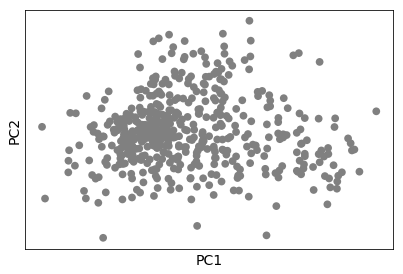

In [59]:
sc.pl.pca_scatter(untreated_subset500)

In [60]:
kmeans500 = KMeans(n_clusters=5, random_state=0).fit(untreated_subset500.X)

In [61]:
kmeans500.labels_

array([4, 4, 1, 2, 2, 2, 4, 1, 4, 4, 4, 2, 1, 4, 4, 4, 1, 4, 1, 1, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 2, 1, 1, 4, 4, 4, 4, 4,
       2, 4, 1, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1, 4, 1, 1, 2, 4, 4, 2, 4, 1,
       4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 1, 4, 1, 1, 2, 1, 4,
       4, 1, 4, 4, 1, 4, 1, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4, 4, 1, 4, 2, 2,
       4, 4, 1, 4, 4, 4, 2, 4, 1, 4, 1, 2, 2, 4, 4, 4, 2, 4, 2, 4, 4, 1,
       4, 4, 4, 4, 4, 2, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 1,
       1, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 1, 4, 1, 4, 2, 4, 4, 2,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 2,
       4, 2, 4, 1, 1, 4, 1, 2, 2, 2, 2, 4, 4, 1, 1, 4, 4, 1, 4, 2, 4, 1,
       4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4,
       1, 4, 1, 1, 2, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 2, 4, 4, 4, 1, 4, 1,
       4, 4, 4, 1, 1, 4, 4, 2, 4, 4, 4, 1, 4, 1, 2,

In [62]:
print(kmeans500.labels_)

[4 4 1 2 2 2 4 1 4 4 4 2 1 4 4 4 1 4 1 1 2 4 4 4 4 4 4 4 4 1 4 4 4 4 1 4 2
 1 1 4 4 4 4 4 2 4 1 4 4 4 2 4 4 4 4 1 1 4 1 1 2 4 4 2 4 1 4 4 2 4 1 4 4 4
 4 4 1 4 4 4 1 1 4 1 1 2 1 4 4 1 4 4 1 4 1 4 4 1 2 4 4 4 4 4 4 4 1 4 2 2 4
 4 1 4 4 4 2 4 1 4 1 2 2 4 4 4 2 4 2 4 4 1 4 4 4 4 4 2 4 0 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 1 4 4 4 4 4 2 4 4 4 4 2 1 1 4 1 4 4 1 1 4 4
 4 4 1 4 4 1 4 1 4 2 4 4 2 1 4 4 4 4 4 4 4 4 1 2 4 1 4 1 4 4 4 4 4 4 2 4 2
 4 1 1 4 1 2 2 2 2 4 4 1 1 4 4 1 4 2 4 1 4 4 4 2 4 2 4 4 2 4 4 4 4 4 4 1 4
 4 4 1 4 4 1 4 1 1 2 4 4 4 4 4 4 1 4 4 4 2 4 4 4 1 4 1 4 4 4 1 1 4 4 2 4 4
 4 1 4 1 2 4 1 2 4 4 4 2 1 4 1 4 2 1 4 4 4 4 1 4 4 1 4 1 4 4 1 4 1 4 4 4 4
 4 4 4 4 4 4 4 4 1 4 1 4 1 4 1 4 2 1 4 4 2 4 4 4 4 4 4 1 4 4 3 4 1 1 2 2 4
 4 4 4 4 1 2 2 4 4 2 4 1 1 4 4 4 1 4 4 4 4 4 4 2 4 4 4 1 4 1 4 1 2 4 4 4 4
 4 1 4 1 4 4 2 1 4 4 4 4 4 4 4 4 4 2 4 4 4 2 4 1 1 4 4 2 4 1 1 4 4 1 2 2 2
 4 1 4 4 1 1 4 4 1 4 2 2 4 1 1 4 1 4 1 4 2 4 4 2 4 4 4 4 4 2 4 2 1 4 4 4 4
 4 4 1 2 4 4 4 4 4 4 4 4 

In [63]:
df500 = pd.DataFrame(kmeans500.labels_)
df500.columns=['KMean']
df500

,KMean
0,4
1,4
2,1
3,2
4,2
5,2
6,4
7,1
8,4
9,4


In [64]:
icantbelievethatworked500 = pd.merge(untreated_subset500.obs, untreated_subset500.obs)

In [65]:
KMeans500 = pd.concat([icantbelievethatworked500, df500], axis=1, join='inner')

In [66]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 500/'
outfile = outpath + 'KMeanDownsizedCellList500_5.csv'
KMeans500.to_csv(outfile, sep='\t')

In [67]:
x=random.sample(range(6577),300)

In [68]:
untreated_subset300 = untreated[x, :]

In [69]:
untreated_subset300.var_names_make_unique()

In [70]:
sc.tl.pca(untreated_subset300)

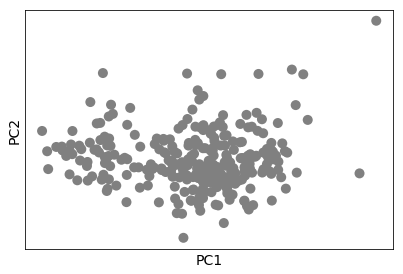

In [71]:
sc.pl.pca_scatter(untreated_subset300)

In [72]:
kmeans300 = KMeans(n_clusters=5, random_state=0).fit(untreated_subset300.X)

In [73]:
kmeans300.labels_

array([0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 3, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0], d

In [74]:
print(kmeans300.labels_)

[0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 4 2 0 0 2 0
 0 0 0 0 0 2 0 0 2 0 2 0 2 0 0 2 0 0 2 0 2 0 0 1 0 2 2 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0
 0 2 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 3 0 2 2 0 0 0 0 2 0
 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0
 0 0 2 0 0 0 0 0 0 2 2 0 0 0 0 0 0 2 0 0 0 2 0 2 2 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 2 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 2 0 2 0 0 0 0
 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0 0 0 0 2
 0 0 0 0]


In [75]:
df300 = pd.DataFrame(kmeans300.labels_)
df300.columns=['KMean']
df300

,KMean
0,0
1,0
2,2
3,0
4,0
5,0
6,0
7,2
8,0
9,0


In [76]:
icantbelievethatworked300 = pd.merge(untreated_subset300.obs, untreated_subset300.obs)

In [77]:
KMeans300 = pd.concat([icantbelievethatworked300, df300], axis=1, join='inner')

In [78]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 300/'
outfile = outpath + 'KMeanDownsizedCellList300_5.csv'
KMeans300.to_csv(outfile, sep='\t')